## Introduction to Computer Vision
## HW 2. Camera trajectory estimation
### Aleksandr Belov

In [1]:
!pip install opencv-python==3.4.2.16 opencv-contrib-python==3.4.2.16

You can download the data here: https://yadi.sk/d/tG6swecSM3GXAQ

In [2]:
import os
import re
import json

import numpy as np
import scipy as sp

from scipy import stats
from scipy.signal import convolve2d

In [3]:
import cv2

from skimage import io
from skimage.util import img_as_ubyte
from skimage.measure import ransac
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
from affine_transform_partial import Translation

In [5]:
PATH_TO_CAPTURED = 'captured'
CAMERA_MATRIX_PATH = 'camera_matrix.json'
IMAGE_IGNORE = [i for i in range(100)] + [i for i in range(316, 340)] + [740, 859]

PINK = (255, 0, 255)
YELLOW = (255, 255, 0)

In [6]:
with open(CAMERA_MATRIX_PATH) as f:
    camera_matrix = np.asarray(json.load(f))
camera_matrix

array([[612.      ,   0.      , 328.467896],
       [  0.      , 612.      , 247.233337],
       [  0.      ,   0.      ,   1.      ]])

In [7]:
def show(image, figsize=(18, 18)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')


def show_img_and_depth(image, depth):
    fig, axs = plt.subplots(1, 2, figsize=(18, 10))
    axs[0].imshow(color)
    axs[1].imshow(depth, cmap=cm.gray)
    axs[0].axis('off')
    axs[1].axis('off')

In [8]:
def get_sorted_captured(path, color='color', depth='depth'):
    captured = os.listdir(path)
    
    is_color = lambda f: f.startswith(color)
    is_depth = lambda f: f.startswith(depth)
    full_path = lambda f: os.path.join(path, f)
    
    color_captured = filter(is_color, captured)
    depth_captured = filter(is_depth, captured)
    
    color_captured = map(full_path, color_captured)
    depth_captured = map(full_path, depth_captured)
    
    num_pattern = re.compile(r'[^\d]*(?P<num>\d+).*')
    find_num = lambda f: int(num_pattern.match(f).group('num'))
    
    color_captured = sorted(color_captured, key=find_num)
    depth_captured = sorted(depth_captured, key=find_num)
    
    return color_captured, depth_captured


def drop_ignore_imgs(imgs):
    return [img for i, img in enumerate(imgs) if i not in IMAGE_IGNORE]

In [9]:
def to_uint_gray(img):
    return img_as_ubyte(rgb2gray(img))


def get_image(path, as_gray=False):
    img = io.imread(path, as_gray=as_gray)
    if as_gray:
        img = to_uint_gray(img)
        
    return img


def get_images(paths, as_gray=False):
    imgs = [get_image(p, as_gray) for p in paths]

    return imgs


def get_depths(paths):
    depths = [io.imread(p) for p in paths]

    return depths

In [10]:
color_captured, depth_captured = get_sorted_captured(PATH_TO_CAPTURED)
color_captured = drop_ignore_imgs(color_captured)
depth_captured = drop_ignore_imgs(depth_captured)

assert len(color_captured) == len(depth_captured)
len(color_captured)

968

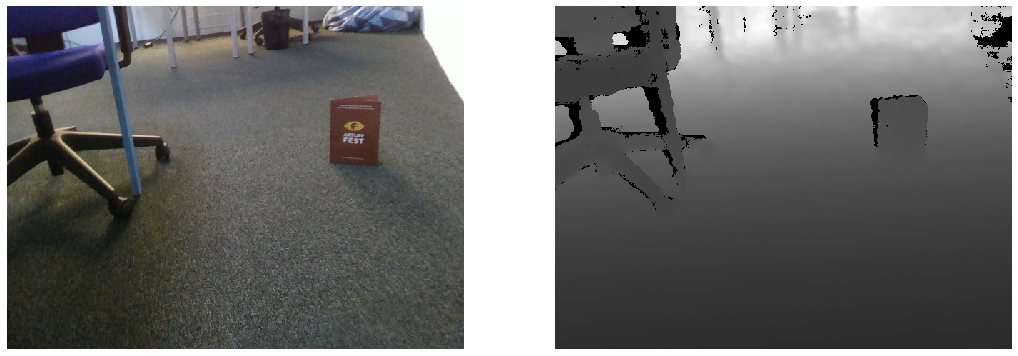

In [11]:
N = 200
color = get_image(color_captured[N])
depth = io.imread(depth_captured[N], as_gray=True)

show_img_and_depth(color, depth)

## 1. Find key points on an image
- The SIFT algorithm is used to find keypoints and descriptors.

In [12]:
def find_sift_keypoints(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)

    return kp, des

In [13]:
N = 750

indexes = (N, N+1)
imgs_in = [color_captured[i] for i in indexes]
print(imgs_in)

src_img, dst_img = get_images(imgs_in)
src_gray, dst_gray = to_uint_gray(src_img), to_uint_gray(dst_img)

src_kp, src_des = find_sift_keypoints(src_gray)
dst_kp, dst_des = find_sift_keypoints(dst_gray)

['captured/color_876.png', 'captured/color_877.png']


/Users/aleksandr.belov/work/tools/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


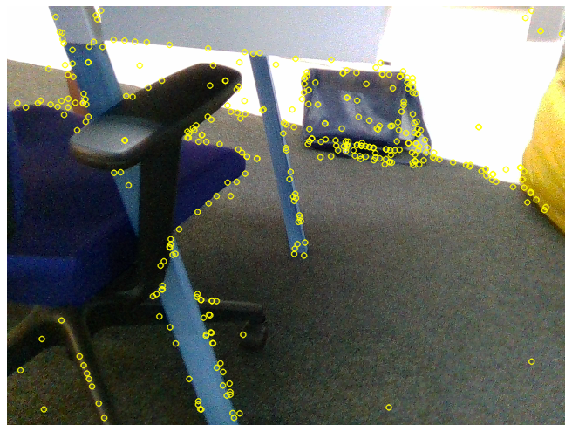

In [14]:
kp_img = cv2.drawKeypoints(src_img, src_kp, None, color=YELLOW)
show(kp_img, figsize=(10, 10))

## 2. Choose two consecutive images and match their keypoints
- The FLANN* based matcher is used.

**Fast Library for Approximate Nearest Neighbors*

In [15]:
def ratio_test(matches, th_ratio):
    test = lambda m, n: 1 if m.distance < th_ratio*n.distance else 0

    matches = [m for m, n in matches if test(m, n)]
    return matches


def match_keypoints(des1, des2, th_ratio=0.5, min_match_cnt=5, k=2):
    flann = cv2.FlannBasedMatcher()
    matches = flann.knnMatch(des1, des2, k=k)
    matches = ratio_test(matches, th_ratio)

    #assert len(matches) > min_match_cnt, f'Not enough matches are found - {len(matches)}/{min_match_cnt}'
    if len(matches) <= min_match_cnt:
        print(f'Not enough matches are found - {len(matches)}/{min_match_cnt}')
    
    return matches

79


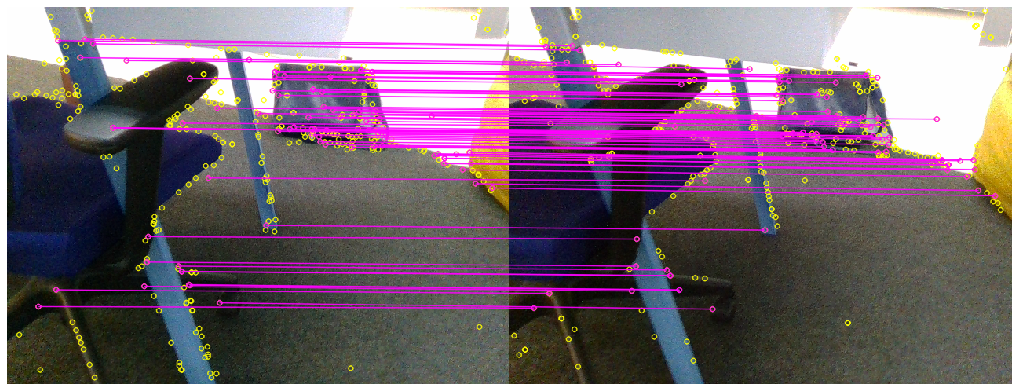

In [16]:
matches = match_keypoints(src_des, dst_des)
print(len(matches))
draw_params = dict(matchColor=PINK,
                   singlePointColor=YELLOW)

match_img = cv2.drawMatches(src_img, src_kp, dst_img, dst_kp, matches, None, **draw_params)

show(match_img)

## 3. Transfer detected keypoints coordinates to the real world coordinates

In [17]:
indexes = (N, N+1)
depth_in = [depth_captured[i] for i in indexes]

src_depths_img, dst_depths_img = get_depths(depth_in)

In [18]:
src_kp_matched = [src_kp[m.queryIdx] for m in matches]
dst_kp_matched = [dst_kp[m.trainIdx] for m in matches]

In [19]:
src_coords_matched = np.asarray([np.round(kp.pt) for kp in src_kp_matched], dtype=int)
src_depths_matched = np.asarray([src_depths_img[j, i] for i, j in src_coords_matched])

dst_coords_matched = np.asarray([np.round(kp.pt) for kp in dst_kp_matched], dtype=int)
dst_depths_matched = np.asarray([dst_depths_img[j, i] for i, j in dst_coords_matched])

In [20]:
def compute_real_world_coordinates(camera_matrix, points, depths, factor=1000):
    inv_camera_matrix = np.linalg.inv(camera_matrix)
    camera_coords = np.vstack((points.T, np.ones(len(points))))
    
    real_world_coords = (inv_camera_matrix @ camera_coords) * depths / factor

    return real_world_coords.T

In [21]:
#rwc is real world coordinates
src_rwc_matched = compute_real_world_coordinates(camera_matrix, src_coords_matched, src_depths_matched)
dst_rwc_matched = compute_real_world_coordinates(camera_matrix, dst_coords_matched, dst_depths_matched)

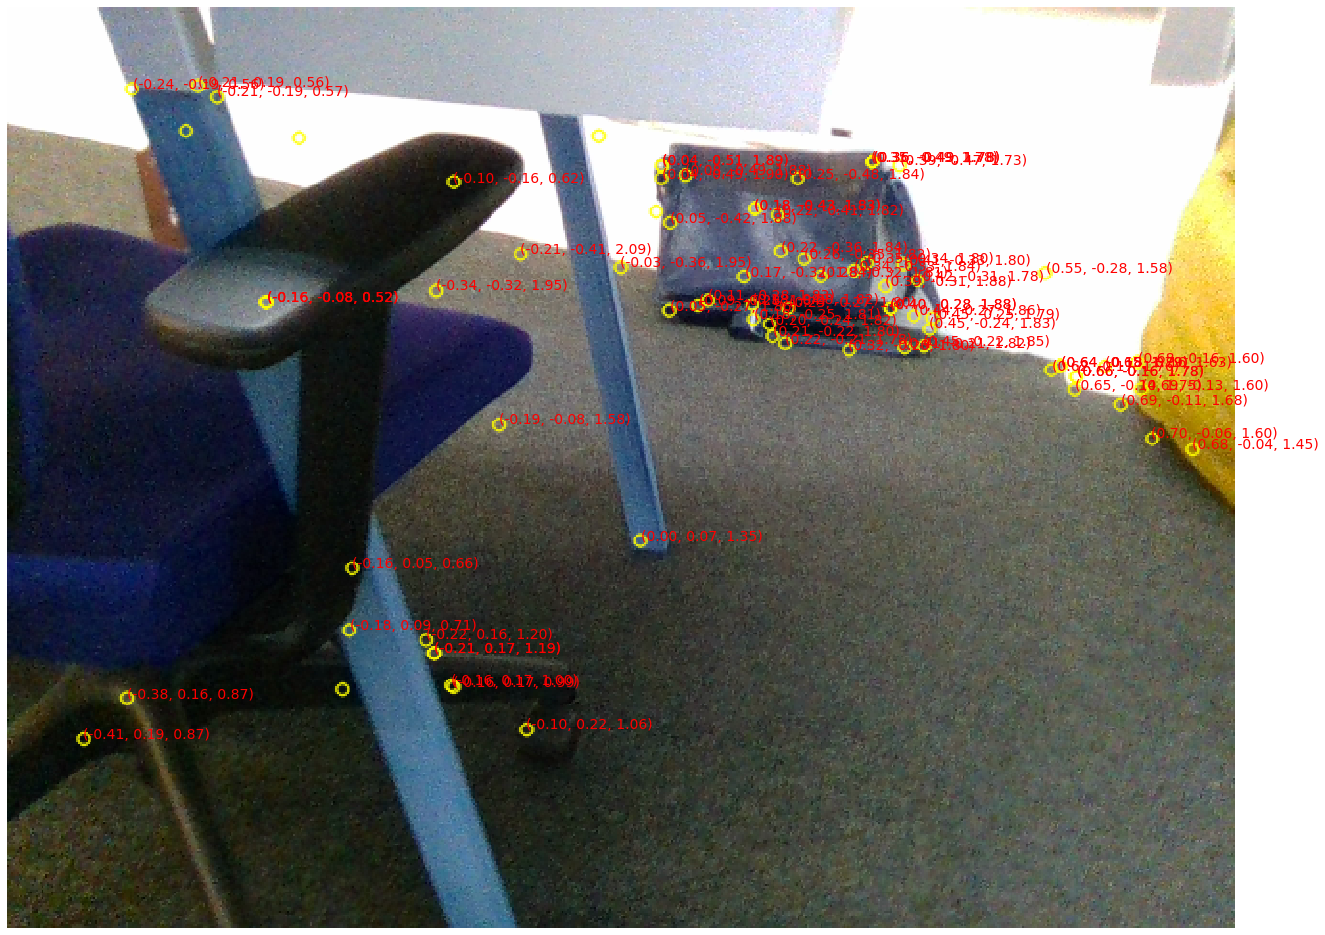

In [22]:
kp_img = cv2.drawKeypoints(src_img, src_kp_matched, None, color=YELLOW)
show(kp_img, figsize=(22, 22))

for (u, v), (x, y, z) in zip(src_coords_matched, src_rwc_matched):
    if z:
        plt.text(u, v, f'({x:.2f}, {y:.2f}, {z:.2f})', dict(color='r', fontsize=14))

## 4. Determine the translation vector and rotation matrix for the same 2 images using RANSAC

In [23]:
def get_non_zero_depth_mask(depths_src, depths_dst):
    non_zero_depths_src = depths_src != 0
    non_zero_depths_dst = depths_dst != 0

    return non_zero_depths_src * non_zero_depths_dst


def get_non_zero_depth_points(src_p, dst_p):
    non_zero_depth_mask = get_non_zero_depth_mask(src_depths_matched, 
                                                  dst_depths_matched)
    src_p = src_p[non_zero_depth_mask]
    dst_p = dst_p[non_zero_depth_mask]

    return src_p, dst_p

In [24]:
non_zero_depth_mask = get_non_zero_depth_mask(src_depths_matched, 
                                              dst_depths_matched)

src_rwc_matched = src_rwc_matched[non_zero_depth_mask]
dst_rwc_matched = dst_rwc_matched[non_zero_depth_mask]
src_depths_matched = src_depths_matched[non_zero_depth_mask]
dst_depths_matched = dst_depths_matched[non_zero_depth_mask]

In [25]:
model_robust, _ = ransac((src_rwc_matched, dst_rwc_matched), Translation, min_samples=3,
                         residual_threshold=2, max_trials=100)

R, t = model_robust.R, model_robust.t

In [26]:
np.linalg.norm(R @ src_rwc_matched.T  + t - dst_rwc_matched.T)

0.20540085512545003

## 5. Find translation vectors and rotation matrices for all pairs of consecutive images 

- Let's combine all previous methods

In [27]:
gray_imgs = get_images(color_captured, as_gray=True)
depths = get_depths(depth_captured)

print(len(gray_imgs), len(depths))

968 968


In [28]:
class CameraMovingConfig:
    def __init__(self):
        
        self._flann = cv2.FlannBasedMatcher()
        self.matcher = lambda src, dst: self._flann.knnMatch(src, dst, k=2)
        
        self._sift = cv2.xfeatures2d.SIFT_create()
        self.kp_detector = lambda img: self._sift.detectAndCompute(img, None)
        
        self._custor_affine_est = Translation
        self.affine_est = lambda src, dst: ransac((src, dst), self._custor_affine_est, min_samples=3,
                                                  residual_threshold=2, max_trials=100)

    @staticmethod
    def ratio_test(matches, th_ratio):
        test = lambda m, n: 1 if m.distance < th_ratio*n.distance else 0

        matches = [m for m, n in matches if test(m, n)]
        return matches


class CameraMoving(CameraMovingConfig):
    def __init__(self, imgs, depths, camera_matrix):

        super().__init__()

        assert len(imgs) == len(depths)

        self.n_imgs = len(imgs)
        self.imgs = imgs
        self.depths = depths
        self.inv_camera_matrix = np.linalg.inv(camera_matrix)

        self.kp = None
        self.des = None
        self.all_matches = None

        self.rotations = None
        self.translations = None

    def detect_kp(self):
        results = [self.kp_detector(img) for img in self.imgs]
        self.kp = [kp for kp, _ in results]
        self.des = [des for _, des in results]

    def match_descriptors(self, th_ratio=0.5, min_match_cnt=5):

        all_matches = []
        i = 0

        for j in range(1, self.n_imgs):

            matches = self.matcher(self.des[i], self.des[j])
            matches = ratio_test(matches, th_ratio)

            assert len(matches) > min_match_cnt, (
                   f'({i}, {j}) Not enough matches are found - {len(matches)}/{min_match_cnt}.')

            all_matches.append(matches)
            i += 1
            
        self.all_matches = all_matches
        
    def compute_pair_rwc(self, points, depths, factor=1000):
        camera_coords = np.vstack((points.T, np.ones(len(points))))
        real_world_coords = (self.inv_camera_matrix @ camera_coords) * depths / factor

        return real_world_coords.T
    
    def get_matched_kp(self, i):
        src_kp_matched = [self.kp[i][m.queryIdx] for m in self.all_matches[i]]
        dst_kp_matched = [self.kp[i+1][m.trainIdx] for m in self.all_matches[i]]
        
        return src_kp_matched, dst_kp_matched
    
    def compute_moving(self, factor=1000):
        
        self.rotations = np.zeros((self.n_imgs-1, 3, 3))
        self.translations = np.zeros((self.n_imgs-1, 3, 1))
    
        for i in range(self.n_imgs-1):
            
            src_kp_matched, dst_kp_matched = self.get_matched_kp(i)
        
            src_coords_matched = np.asarray([np.round(kp.pt) for kp in src_kp_matched], dtype=int)
            src_depths_matched = np.asarray([self.depths[i][k, j] for j, k in src_coords_matched])
            src_rwc_matched = self.compute_pair_rwc(src_coords_matched, src_depths_matched, factor)
            
            dst_coords_matched = np.asarray([np.round(kp.pt) for kp in dst_kp_matched], dtype=int)
            dst_depths_matched = np.asarray([self.depths[i+1][k, j] for j, k in dst_coords_matched])
            dst_rwc_matched = self.compute_pair_rwc(dst_coords_matched, dst_depths_matched, factor)
            
            
            non_zero_depth_mask = get_non_zero_depth_mask(src_depths_matched, 
                                                          dst_depths_matched)

            src_rwc_matched = src_rwc_matched[non_zero_depth_mask]
            dst_rwc_matched = dst_rwc_matched[non_zero_depth_mask]
            
            model, _ = self.affine_est(src_rwc_matched, dst_rwc_matched)
            self.rotations[i] = model.R
            self.translations[i] = model.t

In [29]:
camera = CameraMoving(gray_imgs, depths, camera_matrix)

In [30]:
%%time
camera.detect_kp()

CPU times: user 1min 7s, sys: 21.3 s, total: 1min 28s
Wall time: 49.1 s


In [31]:
%%time
camera.match_descriptors()

CPU times: user 4.2 s, sys: 21.3 ms, total: 4.22 s
Wall time: 4.26 s


In [32]:
%%time
camera.compute_moving()

CPU times: user 1min 18s, sys: 434 ms, total: 1min 18s
Wall time: 1min 19s


## 6. Skip an image if it creates a bad translation vector
- Was skipped at head of file

In [33]:
print(IMAGE_IGNORE)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 740, 859]


## 7. Convert all translations vectors to the coordinate system of the first image

In [34]:
def transform(point, rotate, translate):
    return rotate @ point + translate

def compute_trajectory(rotations, translations):
    
    assert len(rotations) == len(translations)

    trajectory = np.zeros((len(rotations)+1, 3))

    for i, (R, t) in enumerate(zip(rotations, translations), 1):
        trajectory[i] = (R @ trajectory[i-1] + t.T).flatten()

    return trajectory

In [35]:
start_point = np.array([0, 0, 0])

trajectory = compute_trajectory(camera.rotations, camera.translations)

## 8. Draw the camera trajectory with a view from above

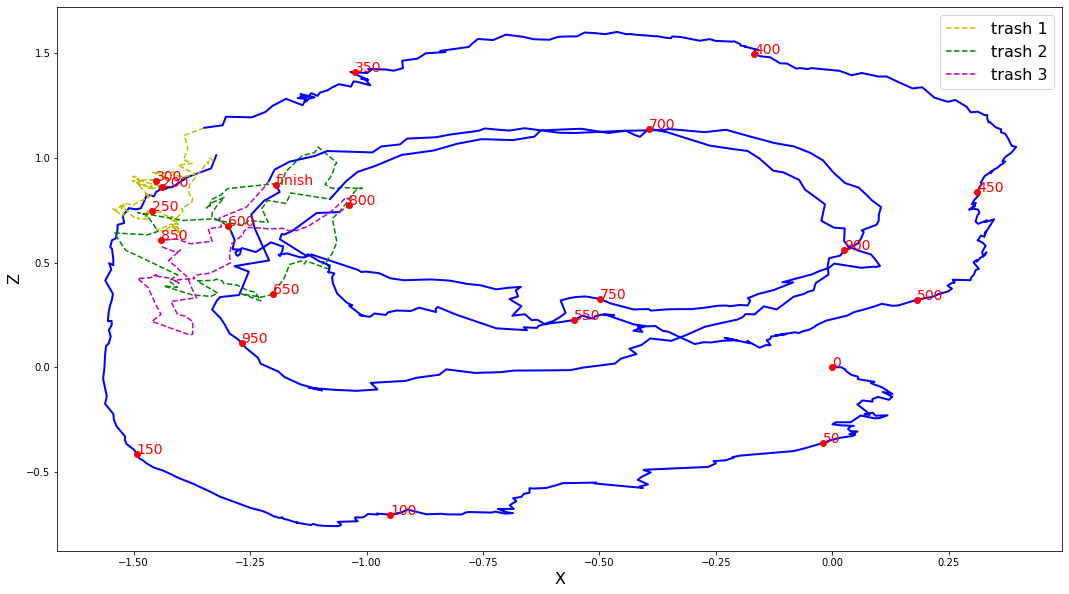

In [38]:
K = 0
M = 210
N = 315
L = 600
P = 685
R = 800
S = 860

plt.figure(figsize=(18, 10))

plt.plot(trajectory[:, 0][K:M],   trajectory[:, 2][K:M], 'b', linewidth=2)
plt.plot(trajectory[:, 0][M:N],   trajectory[:, 2][M:N], 'y--', label='trash 1')
plt.plot(trajectory[:, 0][N-1:L], trajectory[:, 2][N-1:L], 'b', linewidth=2)
plt.plot(trajectory[:, 0][L-1:P], trajectory[:, 2][L-1:P], 'g--', label='trash 2')
plt.plot(trajectory[:, 0][P-1:R], trajectory[:, 2][P-1:R], 'b', linewidth=2)
plt.plot(trajectory[:, 0][R-1:S], trajectory[:, 2][R-1:S], 'm--', label='trash 3')
plt.plot(trajectory[:, 0][S-1:],  trajectory[:, 2][S-1:], 'b', linewidth=2)

for i in range(0, 1000, 50):
    plt.text(trajectory[:, 0][i], trajectory[:, 2][i], str(i), dict(color='r', fontsize=14))
    plt.plot(trajectory[:, 0][i], trajectory[:, 2][i], 'ro')
    
plt.text(trajectory[:, 0][-1], trajectory[:, 2][-1], 'finish', dict(color='r', fontsize=14))
plt.plot(trajectory[:, 0][-1], trajectory[:, 2][-1], 'ro')

plt.legend(loc='best', fontsize=16)
plt.xlabel('X', fontsize=16)
plt.ylabel('Z', fontsize=16)
plt.show()